## Introduction

In [1]:
import sqlite3 
from matplotlib import pyplot as plt 
import numpy as np
from numpy.random import randn 
import pandas as pd
from pandas import Series, DataFrame



class dbopen(object):
    """
    Simple Context Manager to read sql query to load into 
    Commits everything at exit
    """
    
    def __init__(self, path, query=None):
        self.path = path
        self.conn = None
        self.cursor = None
        self.query = query
        self.df = None
    
    def __enter__(self):
        self.conn = sqlite3.connect(self.path)
        self.cursor = self.conn.cursor()
        return self.conn, self.cursor
    
    def __exit__(self, exc_class, exc, traceback):
        self.conn.commit()
        self.conn.close()


In [2]:
database = DataFrame()        
with dbopen("factbook.db") as (conn, c):
    query = "SELECT * FROM sqlite_master WHERE type='table';"
    database = pd.read_sql_query(query, conn)
database.head()

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


## Reading Database Columns and Types

In [3]:
with dbopen("factbook.db") as (conn, c):
    database = pd.read_sql_query("PRAGMA table_info(facts)", conn)

# Fact table column names and type
database

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,1,None,1
1,1,code,varchar(255),1,None,0
2,2,name,varchar(255),1,None,0
3,3,area,integer,0,None,0
4,4,area_land,integer,0,None,0
5,5,area_water,integer,0,None,0
6,6,population,integer,0,None,0
7,7,population_growth,float,0,None,0
8,8,birth_rate,float,0,None,0
9,9,death_rate,float,0,None,0


## Reading the facts table

In [4]:
with dbopen("factbook.db") as (conn, c):
    database = pd.read_sql_query("SELECT * FROM facts", conn)
database.head(3)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92


## Summary Statistics 

In [5]:
with dbopen("factbook.db") as (conn, c):
    query = """
    SELECT MIN(population), MAX(population),
    MIN(population_growth), MAX(population_growth)
    FROM facts
    """
    database = pd.read_sql_query(query, conn)
    
# Read Summary Statistics of Population and Population Growth
database.head()

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


## Exploring Outliers
Interested in country(where column is "name") outliers

In [6]:
# Reading the miniumn population
with dbopen("factbook.db") as (conn, c):
    query = """
    SELECT *
    FROM facts
    WHERE population == (SELECT MIN(population) FROM facts)
    OR population == (SELECT MAX(population) FROM facts)
    """
    database = pd.read_sql_query(query, conn)
database

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000.0,None,0,NaN,NaN,NaN,None
1,261,xx,World,None,NaN,None,7256490011,1.08,18.6,7.8,None


Antarctica has the least population with a population of zero.
The World, that is all the countries combined, has the largest population.

## Histograms
Using just the non-outlier rows, generate a 2 by 2 grid of histograms for the following columns:

    population
    population_growth
    birth_rate
    death_rate


In [7]:
# Reading population, population_growth, birth_rate, death_rate without outliers
with dbopen("factbook.db") as (conn, c):
    query = """
    SELECT population, population_growth, birth_rate, death_rate
    FROM facts
    WHERE population != (SELECT MIN(population) FROM facts)
    AND population != (SELECT MAX(population) FROM facts)
    """
    database = pd.read_sql_query(query, conn)
database.head(3)


,population,population_growth,birth_rate,death_rate
0,32564342,2.32,38.57,13.89
1,3029278,0.30,12.92,6.58
2,39542166,1.84,23.67,4.31


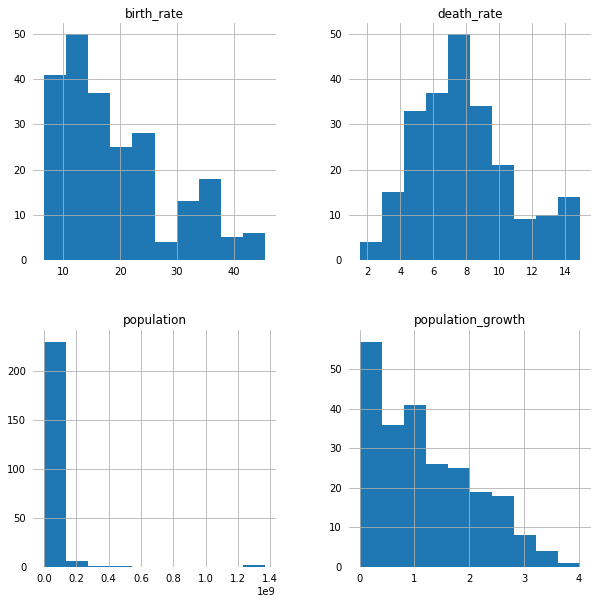

In [8]:
%matplotlib inline

# Plot histogram for each population, population_growth, birth_rate, death_rate without outliers
# Using squeeze=False to return a flatten axes (array[ax,...,ax]) instead of (array[[ax, ax],[ax, ax]])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), squeeze=False)

for ax in database.hist(ax=axes):
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',         # both major and minor ticks are affected
        bottom=False,         # ticks along the bottom edge are off
        top=False,            # ticks along the top edge are off
        left=False,           # ticks along the left edge are off
        labelbottom=True,    # labels along the bottom edge are off
        labelleft=True)
    ax.grid(True)
plt.show()

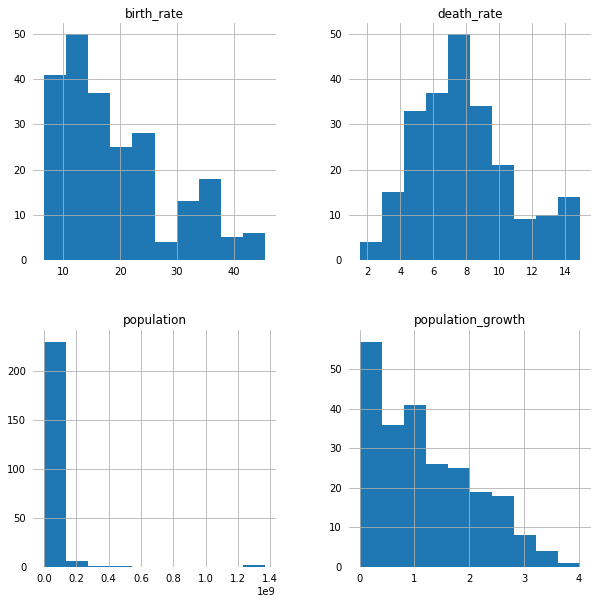

In [9]:
%matplotlib inline

# Plot histogram for each population, population_growth, birth_rate, death_rate without outliers
# Using squeeze=False to return a flatten axes (array[ax,...,ax]) instead of (array[[ax, ax],[ax, ax]])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), squeeze=False)

def plot_clean_hist(df, axes):
    """
    require axes to be unpack into a single array [ax0, ax1, ...., axN]
    For nrows, ncols subplots, use squeeze=False to return a flatten axes 
    (array[ax,...,ax]) instead of (array[[ax, ax],[ax, ax]]) 
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), squeeze=False)
    """
    for ax in df.hist(ax=axes):
        for edge, spine in ax.spines.items():
            spine.set_visible(False)
        ax.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',         # both major and minor ticks are affected
            bottom=False,         # ticks along the bottom edge are off
            top=False,            # ticks along the top edge are off
            left=False,           # ticks along the left edge are off
            labelbottom=True,    # labels along the bottom edge are off
            labelleft=True)
        ax.grid(True)
        
        
plot_clean_hist(database, axes)
plt.show()

## Which countries have the highest population density?

In [10]:
# Reading population, population_growth, birth_rate, death_rate without outliers
with dbopen("factbook.db") as (conn, c):
    query = """
    SELECT name, 
    CAST(population as float)/CAST(area as float) density
    FROM facts
    ORDER BY density DESC
    LIMIT 20
    """
    database = pd.read_sql_query(query, conn)
database

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


Macau has the highest population density. 